In [1]:
from IPython.display import Image
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)
pylab.rcParams['font.size'] = 22
from scipy.constants import epsilon_0, h, hbar, e, pi
from scipy.special import ellipk

Populating the interactive namespace from numpy and matplotlib


In [17]:
import pandas as pd
from os import path, listdir
simdatapath = '/Volumes/PHY-PRL-labshare/Chip Design/JPMQubitV3/Q3D Simulations'
listdir(simdatapath)

['2D Coplanar Coupling.csv',
 'debug_log.scr',
 'GroundMeshSweep_Profile1.csv',
 'image.jpg',
 'XMon_LSweep.csv']

# T-Mon Qubit Design

We want to implement a single-ended qubit design similar to the x-mon design from UCSB. However, we need to couple to a $\lambda/2$ CPW resonator, meaning we have to rethink the geometry in order to facilitate capacitive coupling. By changing the X to a T design, we should be able to satisfy this. 

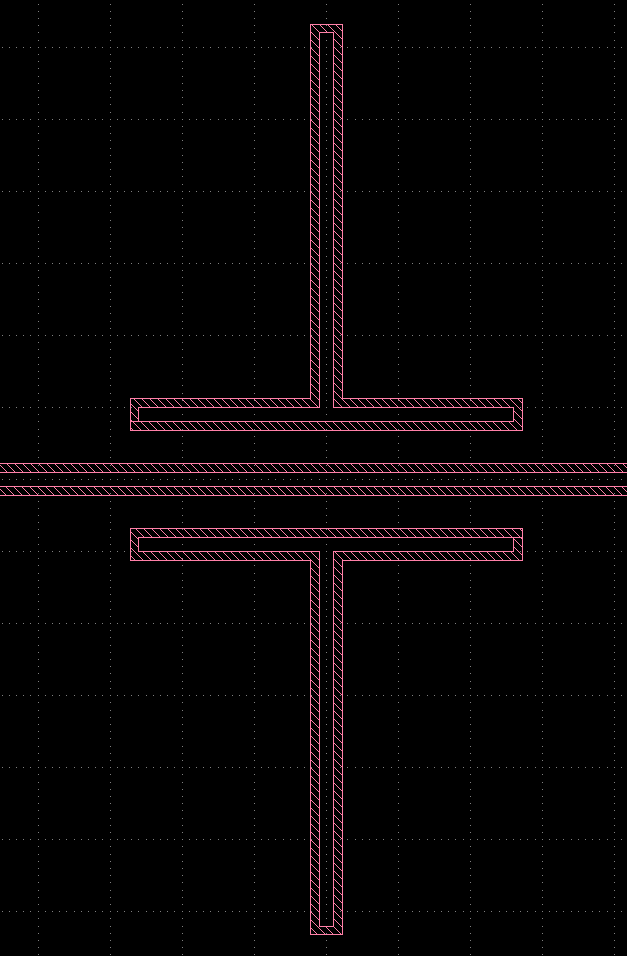

In [2]:
Image('T-mons.png')

Above is a sketch of how we could couple two T-mons to a common CPW resonator.

## Some X-mon parameters

We can extract some circuit parameters from the qubit parameters given in the X-Mon paper:

1. $g=2\pi 40$ MHz
2. $\alpha=230$ MHz
3. $E_J / E_C \approx 95$
4. $\omega_{Qubit} \approx 2\pi 6$ GHz
5. $\omega_{Resonator} \approx 2\pi 6.5$ GHz

Using

$$
g/\omega_r = .00615 = \beta\sqrt{\frac{Z_c e^2}{2\hbar}}, \quad \beta = \frac{C_g}{C_\Sigma} = .0788
$$

and the anharmonicity to calculate $C_\Sigma$

$$
\alpha =230\text{MHz}\approx E_c = \frac{e^2}{2C_\Sigma},\quad C_\Sigma \approx 84 \text{fF}
$$

we can calculate $C_g$

$$
C_g = \beta * C_\Sigma = .0788 \times 84\text{fF} = 6.6\text{fF}
$$

and since $C_\Sigma = C_g + C_b + C_J$

## Qubit Capacitance

The capacitance to ground can be calculated using the capacitance of a CPW:

$$
C/L = \frac{8(\epsilon_0 + \epsilon_{s}) K(k)}{K(k')}
$$

where $k=\frac{s}{(s+2w)}$ and $k' = \sqrt{1-k^2}$.



Here we will use the same coplanar geometry that we use for our resonators:

**Center Conductor** 10 um

**Spacing** 6 um 

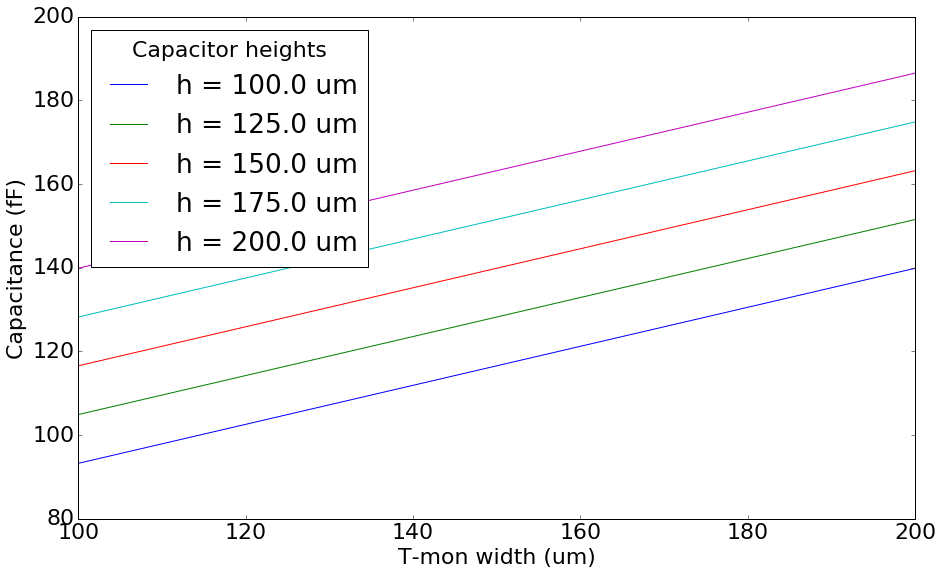

In [4]:
cap_width = linspace(100, 200, 101) * 1e-6 # m
cap_height = linspace(100, 200, 5) * 1e-6 # m

e_sub = 11.6

s=6e-6 # m
w=10e-6 # m

def c_cpw(s, w):
    k = s/(s+2*w)
    kp = sqrt(1-k**2)
    
    return 8*epsilon_0*(1+11.6)*ellipk(k)/ellipk(kp)

# Find C/L for our geometry
c = c_cpw(s, w)

fig, ax = plt.subplots()

for h in cap_height:
    C = cap_width*c + h*c
    ax.plot(cap_width*1e6, C*1e15, label = "h = {} um".format(round(h/1e-6)))

ax.legend(loc=2, title="Capacitor heights")
ax.set_xlim([cap_width[0]*1e6, cap_width[-1]*1e6])
ax.set_xlabel("T-mon width (um)")
ax.set_ylabel("Capacitance (fF)");

## Coupling Capacitance

We are capacitively coupling through a small strip of ground plane to the CPW resonator. Assuming identical CPW parameters, we can calculate the coupling capacitance from through a distance $d$ of ground plane

$$
C_g / L = -\frac{2\epsilon}{\pi}\ln{\left(1 - \left(\frac{w-s/4}{d+w}\right)^2\right)}
$$

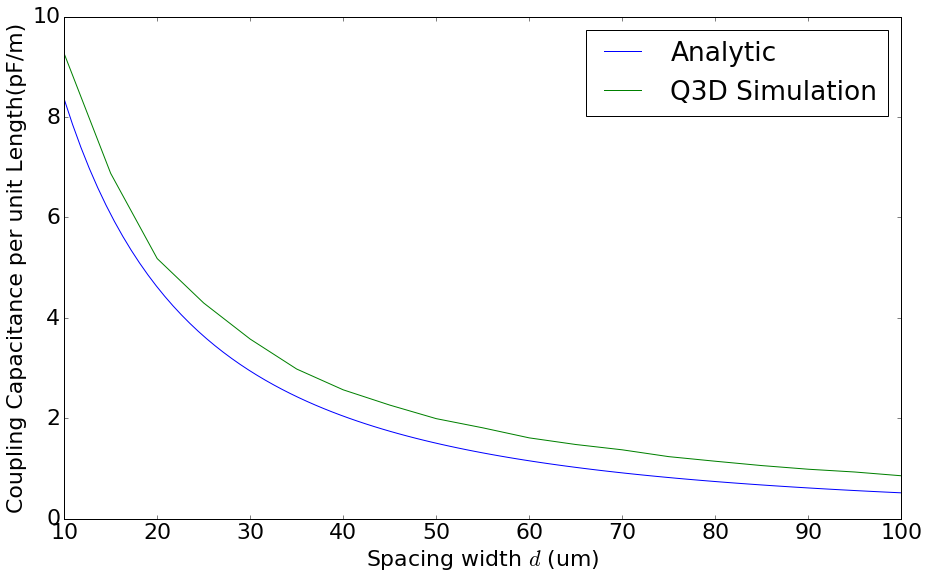

In [24]:
d_spacing = linspace(10, 100, 101)*1e-6 # m
# widths = linspace(100, 200, 5)*1e-6 # m
eps = (11.9 + 1) * epsilon_0 / 2
s = 6*1e-6 #um
w = 16*1e-6 #um

def c_g(s, w, d):
    return -2*eps/pi * log(1- ( (w-s/4)/(d+w) )**2 )

fig, ax = plt.subplots()
ax.plot(d_spacing*1e6, c_g(s, w, d_spacing+s)*1e12, label="Analytic")

# Import Q3D Simulation Data
f = path.join(simdatapath, '2D Coplanar Coupling.csv')
df = pd.read_csv(f)
ax.plot(df[df.keys()[0]], df[df.keys()[1]], label="Q3D Simulation")

ax.legend()
ax.set_xlim([d_spacing[0]*1e6, d_spacing[-1]*1e6])
ax.set_xlabel("Spacing width $d$ (um)")
ax.set_ylabel("Coupling Capacitance per unit Length(pF/m)");

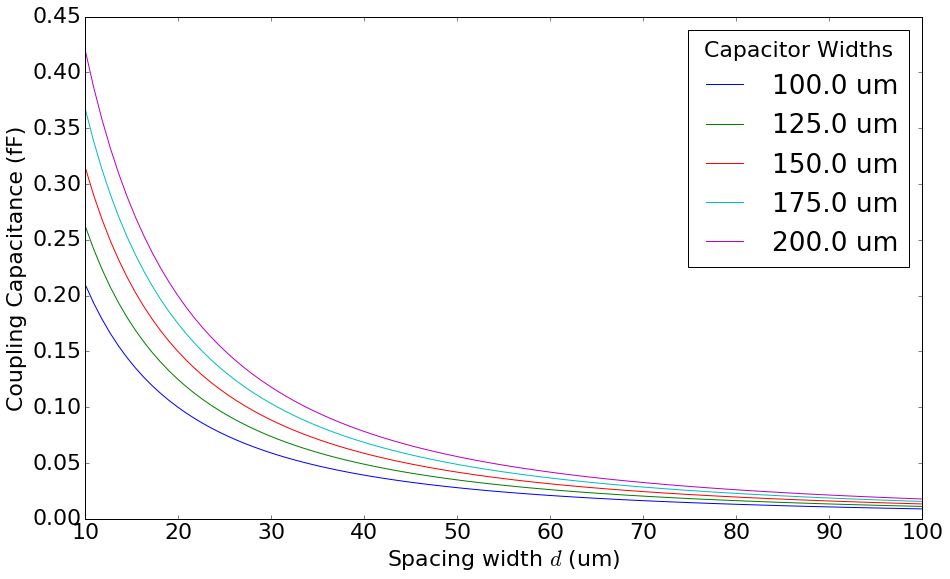

In [9]:
d_spacing = linspace(10, 100, 101)*1e-6 # m
widths = linspace(100, 200, 5)*1e-6 # m

s = 6*1e-6 #um
w = 16*1e-6 #um

def c_g(s, w, d):
    return -2*epsilon_0/pi * log(1- ( (w-s/4)/(d+w) )**2 )

fig, ax = plt.subplots()
for width in widths:
    ax.plot(d_spacing*1e6, width*c_g(s, w, d_spacing)*1e15, label="{} um".format(round(width*1e6)))

ax.legend(title="Capacitor Widths")
ax.set_xlim([d_spacing[0]*1e6, d_spacing[-1]*1e6])
ax.set_xlabel("Spacing width $d$ (um)")
ax.set_ylabel("Coupling Capacitance (fF)");

We can extract a $g$ if we know the cavity frequency and the total qubit frequency $C_\Sigma$. 

$$
g/\omega_r = \beta\sqrt{\frac{Z_c e^2}{2\hbar}} = \frac{C_g}{C_\Sigma}\sqrt{\frac{Z_c e^2}{2\hbar}}
$$

where $C_g$ is the capacitance from the qubit to the resonator, and $C_\Sigma$ is the total capacitance to ground of the qubit $C_g + C_j + C_q$.

Assuming a 100fF Qubit coupled to a 5 GHz cavity with an impedence of $50\Omega$:

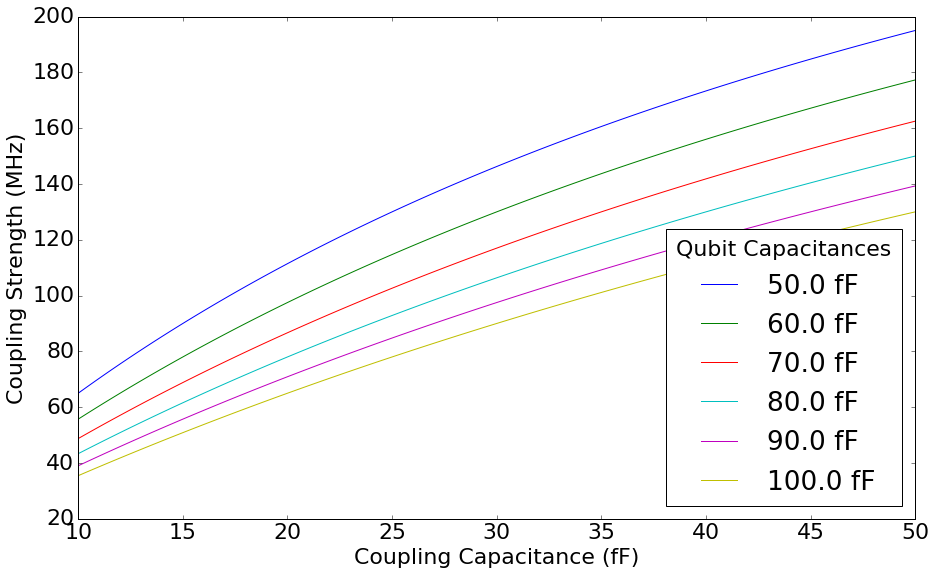

In [6]:
C_g = linspace(1, 5, 101)*1e-14 ## F
C_q = linspace(50, 100, 6)*1e-15 ## F

wr = 5e9 ## Hz

fig, ax = plt.subplots()

for cq in C_q:
    C_sig = C_g + cq
    g = wr*C_g / C_sig * sqrt(50*e**2/2/hbar) # Hz
    ax.plot(C_g*1e15, g/1e6, label="{} fF".format(round(cq*1e15)))

    
ax.legend(loc=4,title="Qubit Capacitances")
ax.set_xlabel("Coupling Capacitance (fF)")
ax.set_ylabel("Coupling Strength (MHz)");

## Z control line

We should be able to use a very similar flux bias line as in the UCSB x-mon design, since we are putting the SQUID loop at the bottom of the T.